In [1]:
DF_PATH       = "../data/processed/1_preprocessed_df.pkl"
FEATURES_PATH = "../data/processed/features_skills_clusters.pkl"

ROLE_COLS      = ['DevType']
TECH_COLS      = ['LanguageHaveWorkedWith',
                  'DatabaseHaveWorkedWith',
                  'PlatformHaveWorkedWith',
                  'WebframeHaveWorkedWith',
                  'MiscTechHaveWorkedWith',
                  'ToolsTechHaveWorkedWith',
                  'NEWCollabToolsHaveWorkedWith']

EXPORT_PATH    = "../data/processed/2_cleaned_data.pkl"

In [91]:
# Load packages
import pandas as pd 
import numpy as np
import pickle

import plotly 
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import silhouette_score

### Read data and preprocess

In [3]:
# Read Data 
processed_df = pd.read_pickle(DF_PATH)
features_df = pd.read_pickle(FEATURES_PATH)

In [4]:
features_df.head()

,skills_group_0,skills_group_1,skills_group_10,skills_group_11,skills_group_12,skills_group_13,skills_group_14,skills_group_15,skills_group_16,skills_group_17,...,skills_group_21,skills_group_22,skills_group_23,skills_group_3,skills_group_4,skills_group_5,skills_group_6,skills_group_7,skills_group_8,skills_group_9
0,4,0,1,0,0,0,0,0,2,0,...,0,0,0,0,0,1,0,2,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,2,0,0,3,0,1,0,0
2,1,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,1,3,0,2,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,2,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,2,4,2,1,0,0


In [5]:
# One hot encode
encoded_dfs = {}
for col in ROLE_COLS + TECH_COLS:
    binarizer = MultiLabelBinarizer()
    encoded_df = pd.DataFrame(binarizer.fit_transform(processed_df[col]),
                               columns=binarizer.classes_,
                               index=processed_df[col].index)
    encoded_dfs[col] = encoded_df

# Merge 1-hot encoded
encoded_dfs = pd.concat(encoded_dfs, axis=1)

### Quick sanity check

In [6]:
# Select random int
i = np.random.randint(processed_df.shape[0])

# Print original values
print(processed_df.iloc[i][ROLE_COLS].tolist())
print(processed_df.iloc[i][TECH_COLS].tolist())
print("----------------")

# Print processed
print(encoded_dfs.iloc[i][encoded_dfs.iloc[i] == 1])
print("----------------")

# Check clustering 
print("Clusters:",features_df.iloc[i].sum())
print("Skills:",  encoded_dfs[TECH_COLS].iloc[i].sum())

[['Developer, mobile']]
[['Node.js', 'Objective-C', 'Swift'], [], ['AWS'], [], [], ['Git'], ['Android Studio', 'Visual Studio Code', 'Xcode']]
----------------
DevType                       Developer, mobile     1
LanguageHaveWorkedWith        Node.js               1
                              Objective-C           1
                              Swift                 1
PlatformHaveWorkedWith        AWS                   1
ToolsTechHaveWorkedWith       Git                   1
NEWCollabToolsHaveWorkedWith  Android Studio        1
                              Visual Studio Code    1
                              Xcode                 1
Name: 58306, dtype: int32
----------------
Clusters: 4
Skills: 8


### Exclude Roles

In [7]:
# Exclude roles
EXCULDE_ROLES = [
    'Other (please specify):',
    'Student',
    'Designer',
    'Educator',
    'Marketing or sales professional',
    'Engineering manager',
    'Senior Executive (C-Suite, VP, etc.)',
    'Product manager',
    'Engineer, site reliability']

In [8]:
for role in EXCULDE_ROLES:
    encoded_dfs = encoded_dfs.drop(("DevType", role), axis=1)

In [9]:
# Check the total samples of roles
original_role_sum = encoded_dfs["DevType"].sum(axis=0)
original_role_sum

Academic researcher                               2899
Data or business analyst                          3792
Data scientist or machine learning specialist     4273
Database administrator                            5655
DevOps specialist                                 7058
Developer, QA or test                             3611
Developer, back-end                              29071
Developer, desktop or enterprise applications    11036
Developer, embedded applications or devices       4598
Developer, front-end                             18231
Developer, full-stack                            32891
Developer, game or graphics                       2112
Developer, mobile                                 9800
Engineer, data                                    4176
Scientist                                         2015
System administrator                              6079
dtype: int64

### Filter data (Responses)

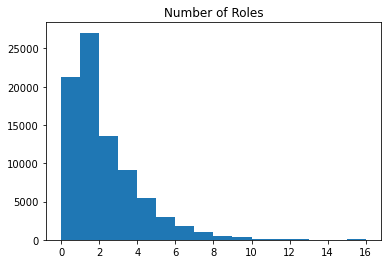

In [10]:
freq_roles = encoded_dfs[ROLE_COLS].sum(axis=1)
plt.hist(freq_roles, freq_roles.max())
plt.title('Number of Roles')
plt.show()

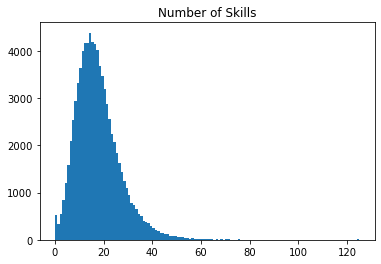

In [11]:
freq_tech = encoded_dfs[TECH_COLS].sum(axis=1)
plt.hist(freq_tech, freq_tech.max())
plt.title('Number of Skills')
plt.show()

In [12]:
# Filter frequencies 
ROLES_RANGE = [1,3]
TECH_RANGE  = [3,30]

In [13]:
# Create masks 
role_mask   = (freq_roles >= ROLES_RANGE[0]) & (freq_roles <= ROLES_RANGE[1])
tech_mask   = (freq_tech >= TECH_RANGE[0])   & (freq_tech <= TECH_RANGE[1])
filter_mask = role_mask & tech_mask

In [14]:
features_df = features_df.loc[filter_mask].copy()
encoded_dfs = encoded_dfs.loc[filter_mask].copy()

In [15]:
# Check the total samples of roles
cleaned_role_sum = encoded_dfs["DevType"].sum(axis=0)
cleaned_role_sum

Academic researcher                               1708
Data or business analyst                          1658
Data scientist or machine learning specialist     2460
Database administrator                            1210
DevOps specialist                                 3056
Developer, QA or test                             1135
Developer, back-end                              17084
Developer, desktop or enterprise applications     4845
Developer, embedded applications or devices       2138
Developer, front-end                              8932
Developer, full-stack                            20655
Developer, game or graphics                        899
Developer, mobile                                 4751
Engineer, data                                    1941
Scientist                                         1046
System administrator                              2069
dtype: int64

In [16]:
encoded_dfs.reset_index(drop=True, inplace=True)
encoded_dfs.head()

DevType                           \
  Academic researcher Data or business analyst   
0                   0                        0   
1                   0                        0   
2                   0                        0   
3                   0                        0   
4                   0                        0   

                                                                        \
  Data scientist or machine learning specialist Database administrator   
0                                             0                      0   
1                                             0                      0   
2                                             0                      0   
3                                             0                      0   
4                                             1                      0   

                                                               \
  DevOps specialist Developer, QA or test Developer, back-end   
0                 0                     0                   0   
1                 0                     0                   0   
2                 0                     0                   0   
3                 0                     0                   0   
4                 0                     0                   0   

                                                 \
  Developer, desktop or enterprise applications   
0                                             0   
1                                             0   
2                                             1   
3                                             0   
4                                             0   

                                                                    ...  \
  Developer, embedded applications or devices Developer, front-end  ...   
0                                           0                    0  ...   
1                                           0                    1  ...   
2                                           0                    0  ...   
3                                           0                    1  ...   
4                                           0                    0  ...   

  NEWCollabToolsHaveWorkedWith                                           \
                       RStudio Rider RubyMine Sublime Text TextMate Vim   
0                            0     0        0            0        0   0   
1                            0     0        0            0        0   0   
2                            0     0        0            0        0   1   
3                            0     0        0            1        0   0   
4                            0     0        0            0        0   1   

                                                   
  Visual Studio Visual Studio Code Webstorm Xcode  
0             0                  0        0     1  
1             0                  0        0     0  
2             0                  0        0     0  
3             0                  0        0     0  
4             0                  1        0     0  

[5 rows x 141 columns]

### Merge & Export data

In [17]:
# Add second level indexing 
features_df.columns = pd.MultiIndex.from_product([['skills_clusters'], 
                                                  features_df.columns])

In [18]:
# Concatenate
df = pd.concat([encoded_dfs, features_df], axis=1)

In [19]:
# Export 
df.to_pickle(EXPORT_PATH)